<a href="https://colab.research.google.com/github/sophiezydfifi/207fall-project-ding-peteh-valadez-zhang/blob/main/207_Milestone_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data processing**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
# upload the file and please replace the file link
df = pd.read_csv("/content/NBA Player Stats and Salaries_2010-2025.csv")
print(df.shape)
df.head()

(7298, 31)


,Player,Salary,Year,Pos,Age,Team,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,23034375,2010,SG,31,LAL,73,73,38.8,9.8,...,0.811,1.1,4.3,5.4,5.0,1.5,0.3,3.2,2.6,27.0
1,Jermaine O'Neal,23016000,2010,C,31,MIA,70,70,28.4,5.6,...,0.720,1.8,5.2,6.9,1.3,0.4,1.4,1.8,3.0,13.6
2,Tracy McGrady,22843124,2010,SG,30,NYK,30,24,22.4,3.0,...,0.746,0.7,2.4,3.1,3.3,0.5,0.5,1.5,1.3,8.2
3,Tim Duncan,22183220,2010,C,33,SAS,78,77,31.3,7.2,...,0.725,2.8,7.3,10.1,3.2,0.6,1.5,1.8,1.9,17.9
4,Shaquille O'Neal,21000000,2010,C,37,CLE,53,53,23.4,4.9,...,0.496,1.8,4.9,6.7,1.5,0.3,1.2,2.0,3.2,12.0


In [ ]:
# Quick structure overview
df.info()

# Check missing values
df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7298 entries, 0 to 7297
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7298 non-null   object 
 1   Salary  7298 non-null   int64  
 2   Year    7298 non-null   int64  
 3   Pos     7298 non-null   object 
 4   Age     7298 non-null   int64  
 5   Team    7298 non-null   object 
 6   G       7298 non-null   int64  
 7   GS      7298 non-null   int64  
 8   MP      7298 non-null   float64
 9   FG      7298 non-null   float64
 10  FGA     7298 non-null   float64
 11  FG%     7278 non-null   float64
 12  3P      7298 non-null   float64
 13  3PA     7298 non-null   float64
 14  3P%     6713 non-null   float64
 15  2P      7298 non-null   float64
 16  2PA     7298 non-null   float64
 17  2P%     7253 non-null   float64
 18  eFG%    7278 non-null   float64
 19  FT      7298 non-null   float64
 20  FTA     7298 non-null   float64
 21  FT%     7096 non-null   float64
 22  

,0
3P%,585
FT%,202
2P%,45
FG%,20
eFG%,20
Pos,0
Player,0
G,0
Team,0
GS,0


In [ ]:
# For the missing values. They are all data derived from other non-missing columns. Hence I can fill percentage columns with 0
perc_cols = ["3P%", "FT%", "2P%", "FG%", "eFG%"]
df[perc_cols] = df[perc_cols].fillna(0)

# Double check
df[perc_cols].isnull().sum()

,0
3P%,0
FT%,0
2P%,0
FG%,0
eFG%,0


In [ ]:
# I want to adjust all the salary from different years to the level of 2025 based on the NBA cap. (https://www.spotrac.com/nba/cba/)
#Salary Cap Maximum values (from  the NBA salary Cap table, 2010–2025)
cap_data = {
    "Year": [
        2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025
    ],
    "Cap": [
        58040000, 58044000, 58044000, 58679000,
        63065000, 70000000, 94143000, 99093000,
        101869000, 109140000, 109140000, 112414000,
        123655000, 136021000, 140588000, 154647000
    ]
}

cap_df = pd.DataFrame(cap_data)
cap_df

,Year,Cap
0,2010,58040000
1,2011,58044000
2,2012,58044000
3,2013,58679000
4,2014,63065000
5,2015,70000000
6,2016,94143000
7,2017,99093000
8,2018,101869000
9,2019,109140000


In [ ]:
# Merge salary cap info into NBA dataset
df_adj = df.merge(cap_df, on="Year", how="left")
# Define 2025 cap
cap_2025 = 154647000

# Adjust all salaries to 2025 cap level
df_adj["Salary_2025_Adjusted"] = df_adj["Salary"] * (cap_2025 / df_adj["Cap"])

In [ ]:
# encode categorical values like position and team
df_working = pd.get_dummies(df_adj, columns=["Pos", "Team"], drop_first=True)

In [ ]:
#Classify the salary into low, mid and high categories
# Define quantile cutoffs (33rd and 66th percentiles)
q33 = df_working["Salary_2025_Adjusted"].quantile(0.33)
q66 = df_working["Salary_2025_Adjusted"].quantile(0.66)

# Create a categorical variable for salary tiers
def categorize_salary(salary):
    if salary <= q33:
        return "Low"
    elif salary <= q66:
        return "Medium"
    else:
        return "High"

class_order = ["Low", "Medium", "High"]

df_working["Salary_Tier"] = df_working["Salary_2025_Adjusted"].apply(categorize_salary)

# Quick check of class balance
print(df_working["Salary_Tier"].value_counts())



Salary_Tier
High      2481
Low       2409
Medium    2408
Name: count, dtype: int64


In [ ]:
# check shape to head into splitting
print('Shape of data', df_working.shape)
df_working.head(800)

Shape of data (7298, 78)


,Player,Salary,Year,Age,G,GS,MP,FG,FGA,FG%,...,Team_ORL,Team_PHI,Team_PHO,Team_POR,Team_SAC,Team_SAS,Team_TOR,Team_UTA,Team_WAS,Salary_Tier
0,Kobe Bryant,23034375,2010,31,73,73,38.8,9.8,21.5,0.456,...,False,False,False,False,False,False,False,False,False,High
1,Jermaine O'Neal,23016000,2010,31,70,70,28.4,5.6,10.6,0.529,...,False,False,False,False,False,False,False,False,False,High
2,Tracy McGrady,22843124,2010,30,30,24,22.4,3.0,7.8,0.387,...,False,False,False,False,False,False,False,False,False,High
3,Tim Duncan,22183220,2010,33,78,77,31.3,7.2,13.9,0.518,...,False,False,False,False,False,True,False,False,False,High
4,Shaquille O'Neal,21000000,2010,37,53,53,23.4,4.9,8.7,0.566,...,False,False,False,False,False,False,False,False,False,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Dante Cunningham,762195,2011,23,78,18,21.0,2.8,6.1,0.462,...,False,False,False,False,False,False,False,False,False,Low
796,Derrick Brown,762195,2011,23,49,1,11.8,1.5,2.7,0.565,...,False,False,False,False,False,False,False,False,False,Low
797,A.J. Price,762195,2011,24,50,0,15.9,2.3,6.4,0.356,...,False,False,False,False,False,False,False,False,False,Low
798,DaJuan Summers,762195,2011,23,22,1,9.0,1.3,3.1,0.406,...,False,False,False,False,False,False,False,False,False,Low


In [ ]:
# permutation for shuffling
np.random.seed(0)
n   = len(df_working)
idx = np.random.permutation(n)

# reset and clean up the index from gaps in preprocessing
df_working = df_working.reset_index(drop = True).iloc[idx].reset_index(drop = True)

In [ ]:
# features of interest
num_features = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
cat_features = ['Pos_C-PF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-C', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF',
                'Team_BOS', 'Team_BRK', 'Team_CHA', 'Team_CHI', 'Team_CHO', 'Team_CLE', 'Team_DAL', 'Team_DEN', 'Team_DET', 'Team_GSW', 'Team_HOU', 'Team_IND', 'Team_LAC', 'Team_LAL', 'Team_MEM', 'Team_MIA',
                'Team_MIL', 'Team_MIN', 'Team_NJN', 'Team_NOH', 'Team_NOP', 'Team_NYK', 'Team_OKC', 'Team_ORL', 'Team_PHI', 'Team_PHO', 'Team_POR', 'Team_SAC', 'Team_SAS', 'Team_TOR', 'Team_UTA', 'Team_WAS']

# define features for the training
X = df_working[num_features + cat_features]  # drop columns I don't want to use

y = df_working["Salary_2025_Adjusted"]

In [ ]:
# split data 60 train 20 val 20 test
x_train, x_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.40, random_state = 1234)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size = 0.50, random_state = 1234)

In [ ]:
#Many ML models (regression, KNN, neural nets) need features on similar scales.
#Tree models (Random Forest, Gradient Boosting) don’t need scaling, but it’s fine to keep a standardized version for consistency.
from sklearn.preprocessing import StandardScaler

#numeric standardization
scaler = StandardScaler()

# fits standardization on x_train keeps column names and preserve row shuffle
x_train_num = pd.DataFrame(
    scaler.fit_transform(x_train[num_features]),
    columns = num_features,
    index = x_train.index
)

# fits same scaler on x_val keeps column names and preserve row shuffle
x_val_num = pd.DataFrame(
    scaler.transform(x_val[num_features]),
    columns = num_features,
    index = x_val.index
)

# fits same scaler on x_test keeps column names and preserve rows
x_test_num = pd.DataFrame(
    scaler.transform(x_test[num_features]),
    columns = num_features,
    index = x_test.index
)

In [ ]:
# put together standardized features
x_train_scaled = pd.concat([x_train_num, x_train[cat_features]], axis = 1)
x_val_scaled = pd.concat([x_val_num, x_val[cat_features]], axis = 1)
x_test_scaled = pd.concat([x_test_num, x_test[cat_features]], axis = 1)

print("x_train_scaled: ", x_train_scaled.shape, " y_train: ", y_train.shape)
print("x_val_scaled: ", x_val_scaled.shape,   " y_val: ", y_val.shape)
print("x_test_scaled: ", x_test_scaled.shape,  " y_test: ", y_test.shape)

x_train_scaled:  (4378, 72)  y_train:  (4378,)
x_val_scaled:  (1460, 72)  y_val:  (1460,)
x_test_scaled:  (1460, 72)  y_test:  (1460,)


# **EDA and visualizations**

In [ ]:
# plot the salary graph to show distribution
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

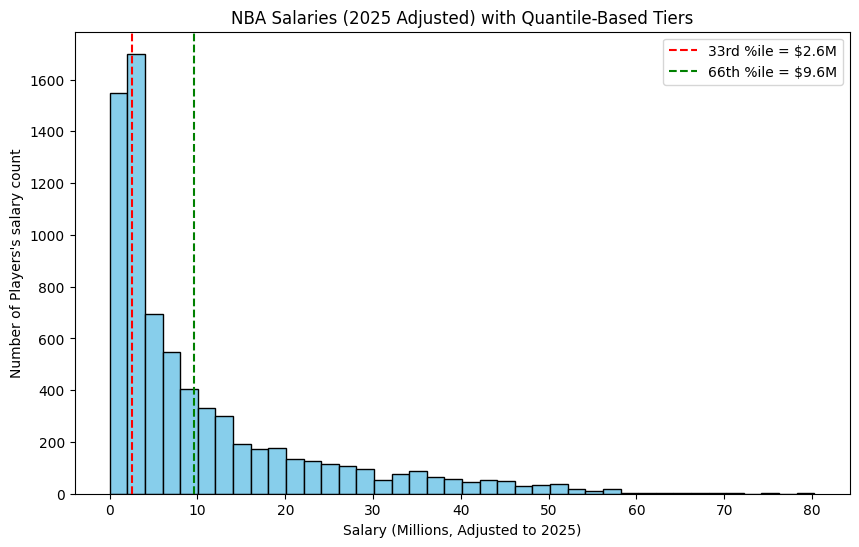

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df_adj["Salary_2025_Adjusted"]/1e6, bins=40, color="skyblue", edgecolor="black")
plt.axvline(q33/1e6, color="red", linestyle="--", label=f"33rd %ile = ${q33/1e6:.1f}M")
plt.axvline(q66/1e6, color="green", linestyle="--", label=f"66th %ile = ${q66/1e6:.1f}M")
plt.title("NBA Salaries (2025 Adjusted) with Quantile-Based Tiers")
plt.xlabel("Salary (Millions, Adjusted to 2025)")
plt.ylabel("Number of Players's salary count")
plt.legend()
plt.show()

In [ ]:
# scatter plolt salary vs season pts avg
brush = alt.selection_interval()
scatter = alt.Chart(df_adj).mark_circle().encode(
    x = alt.X("PTS:Q", title = "Season Points"),
    y = alt.Y("Salary:Q", title = "Salary"),
    color = alt.condition(brush, "Pos:N", alt.value("lightgray")),
    tooltip = ["Player","Team","Year","PTS","Salary","Pos"]
).add_params(brush).properties(title="Points vs Salary")

In [ ]:
scatter

alt.Chart(...)

In [ ]:
# numeric features correlation heatmap
corr = df_adj[num_features].corr().stack().reset_index()
corr.columns = ["feature_x","feature_y","corr"]

heatmap = alt.Chart(corr).mark_rect().encode(
    x = alt.X("feature_x:N", sort = num_features, title = ""),
    y = alt.Y("feature_y:N", sort = num_features, title = ""),
    color = alt.Color("corr:Q", scale = alt.Scale(scheme = "redblue", domain = [-1,1])),
    tooltip = ["feature_x","feature_y","corr"]
).properties(title = "Correlation Heatmap")

In [ ]:
heatmap

alt.Chart(...)